# Python version 3.11
```bash
conda create -n llama311 python=3.11
conda activate llama311
conda install -c conda-forge pytorch torchvision dask distributed zarr tqdm ipywidgets
conda install -c conda-forge rioxarray scipy matplotlib xarray ipykernel
pip install simple-lama-inpainting
python -m ipykernel install --user --name llama311
```

# Tree masking

- [source data](https://registry.opendata.aws/dataforgood-fb-forests/)
- The 1 meter resolution source product gives canopy height to the nearest 1 meter. So we say that anything with non-zero canopy height is canopy covered to get a binary 1 meter product. then average that within the 10 meter cells
- effectively the number of 1m  cells within a 10m cell that have canopy height above threshold of 1 meter

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import rioxarray
import xarray
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
from PIL import Image
from tqdm.notebook import tqdm
import math

In [3]:
%matplotlib widget

In [4]:
from simple_lama_inpainting import SimpleLama
simple_lama = SimpleLama(device="cuda")

# Read Data

In [5]:
region = 'UCSB'
ds = xarray.open_zarr(f'/scratch/tristate/{region}_postprocessed.zarr/', consolidated=False)

In [6]:
coarse = 10

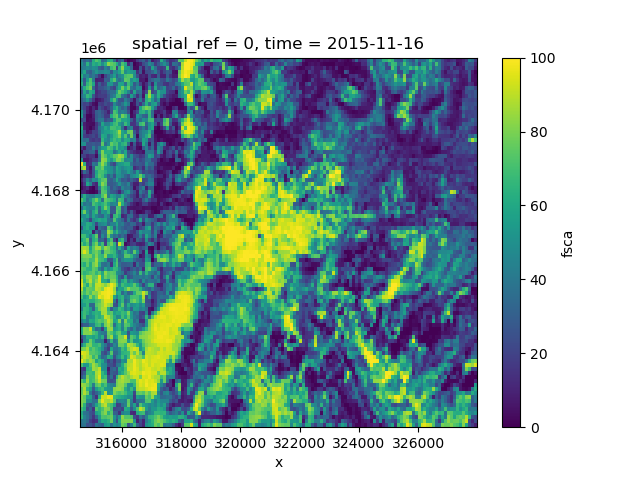

In [7]:
ds['fsca'].isel(time=1).coarsen(x=coarse, y=coarse, boundary='trim').mean().plot()

In [8]:
fsca_da = ds['fsca']

# Read Mask

In [9]:
trees_da = rioxarray.open_rasterio(f'/data/canopy/{region.lower()}_10m_canopy_cover_percent.tif').squeeze()

In [10]:
trees_da = trees_da.rio.clip_box(*ds.rio.bounds())

In [11]:
n = 1

tree_mask = xarray.where(trees_da>10, True, False)
structure = np.ones((2*n + 1, 2*n + 1), dtype=bool)
buffer = scipy.ndimage.binary_dilation(tree_mask, structure=structure)
mask_da = xarray.DataArray(buffer.astype(int), coords=tree_mask.coords, dims=tree_mask.dims)
mask_da = xarray.where(mask_da, True, False)

In [12]:
mask_da

<xarray.DataArray (y: 920, x: 1346)> Size: 1MB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])
Coordinates:
  * y            (y) float64 7kB 4.171e+06 4.171e+06 ... 4.162e+06 4.162e+06
  * x            (x) float64 11kB 3.146e+05 3.146e+05 ... 3.28e+05 3.28e+05
    band         int64 8B 1
    spatial_ref  int64 8B 0

# Define funct

In [13]:
def process_slice(fsca, mask):   
    fsca = (fsca.fillna(0)/100*255).astype(np.uint8).expand_dims({'band':3})
    fsca_np = fsca.values.T
    fsca_pil = Image.fromarray(fsca_np)
    
    mask_np = mask.values.T
    mask_np = (mask_np *255).astype(np.uint8)
    mask_pil = Image.fromarray(mask_np)
    
    result_pil = simple_lama(fsca_pil, mask_pil)

    lenx, leny, bands = fsca_np.shape
    result = np.asarray(result_pil)[:lenx, :leny, 0].T
    
    return result

In [14]:
def process_in_patches(
    fsca_da,
    mask_da,    
    patch_size_y=5000,
    patch_size_x=5000,
    overlap=50,
):

    ny, nx = fsca_da.shape
    out = np.zeros((ny, nx), dtype=np.float32)
    counts = np.zeros((ny, nx), dtype=np.float32)

    # Patch movement steps
    step_y = patch_size_y - overlap
    step_x = patch_size_x - overlap

    y_starts = list(range(0, ny, step_y))
    x_starts = list(range(0, nx, step_x))

    # Iterate patches
    for y0 in y_starts:
        for x0 in x_starts:
            y1 = min(y0 + patch_size_y, ny)
            x1 = min(x0 + patch_size_x, nx)

            f_patch = fsca_da.isel(y=slice(y0, y1), x=slice(x0, x1))
            m_patch = mask_da.isel(y=slice(y0, y1), x=slice(x0, x1))

            res_patch = process_slice(f_patch, m_patch)            

            out[y0:y1, x0:x1] += res_patch
            counts[y0:y1, x0:x1] += 1

    out = out / np.maximum(counts, 1)
    result_da = xarray.DataArray(out, coords={'y': fsca_ts.coords['y'], 'x': fsca_ts.coords['x']})
    return result_da

In [15]:
def divisors(n):
    divs = []
    for i in range(1, int(math.sqrt(n)) + 1):
        if n % i == 0:
            divs.append(i)
            divs.append(n // i)
    return sorted(set(divs))


def patch_size_from_factors(dim, max_patch, overlap):
    effective = dim - overlap
    if effective <= 0:
        return max_patch  # degenerate case

    best = None

    for step in divisors(effective):
        patch_size = step + overlap

        if patch_size <= max_patch:
            if best is None or patch_size > best:
                best = patch_size
    
    return best if best is not None else max_patch
    
def get_patch_sizes_factorized(da, max_y, max_x, overlap):
    ny, nx = da.shape

    py = patch_size_from_factors(ny, max_y, overlap)
    px = patch_size_from_factors(nx, max_x, overlap)

    return py, px

# timeslice

In [134]:
fsca_ts = fsca_da.isel(time=111)
fsca_ts

<xarray.DataArray 'fsca' (y: 920, x: 1346)> Size: 5MB
dask.array<getitem, shape=(920, 1346), dtype=float32, chunksize=(920, 1346), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 7kB 4.171e+06 4.171e+06 ... 4.162e+06 4.162e+06
  * x            (x) float64 11kB 3.146e+05 3.146e+05 ... 3.28e+05 3.28e+05
    spatial_ref  int64 8B ...
    time         datetime64[ns] 8B 2018-11-10

In [135]:
max_patch = 7_000
overlap = 100
patch_size_y, patch_size_x = get_patch_sizes_factorized(fsca_ts, max_y=max_patch, max_x=max_patch, overlap=overlap)
patch_size_y, patch_size_x

(920, 1346)

In [136]:
%%time
result_da = process_in_patches(fsca_ts, mask_da, patch_size_y=patch_size_y, patch_size_x=patch_size_x, overlap=overlap)
result_da = result_da / 255*100.0

CPU times: user 313 ms, sys: 20 ms, total: 333 ms
Wall time: 348 ms


In [137]:
fig, axs = plt.subplots(figsize=(16, 3.5), dpi=100, nrows=1, ncols=3)

coarse = 1
#mask_da.coarsen(x=coarse, y=coarse, boundary='trim').mean().plot(ax=axs[0], add_colorbar=False, alpha=1)
fsca_ts.coarsen(x=coarse, y=coarse, boundary='trim').mean().plot(ax=axs[0], add_colorbar=False, alpha=1)
xarray.where(mask_da==False, fsca_ts, np.nan).coarsen(x=coarse, y=coarse, boundary='trim').mean().plot(ax=axs[1], add_colorbar=False, alpha=1)

result_da.coarsen(x=coarse, y=coarse, boundary='trim').mean().plot(ax=axs[2], add_colorbar=True, alpha=1)

for ax in axs:
    ax.set_aspect('equal')
    ax.axis('off')
    ax.title.set_visible(False)
    fig.tight_layout()

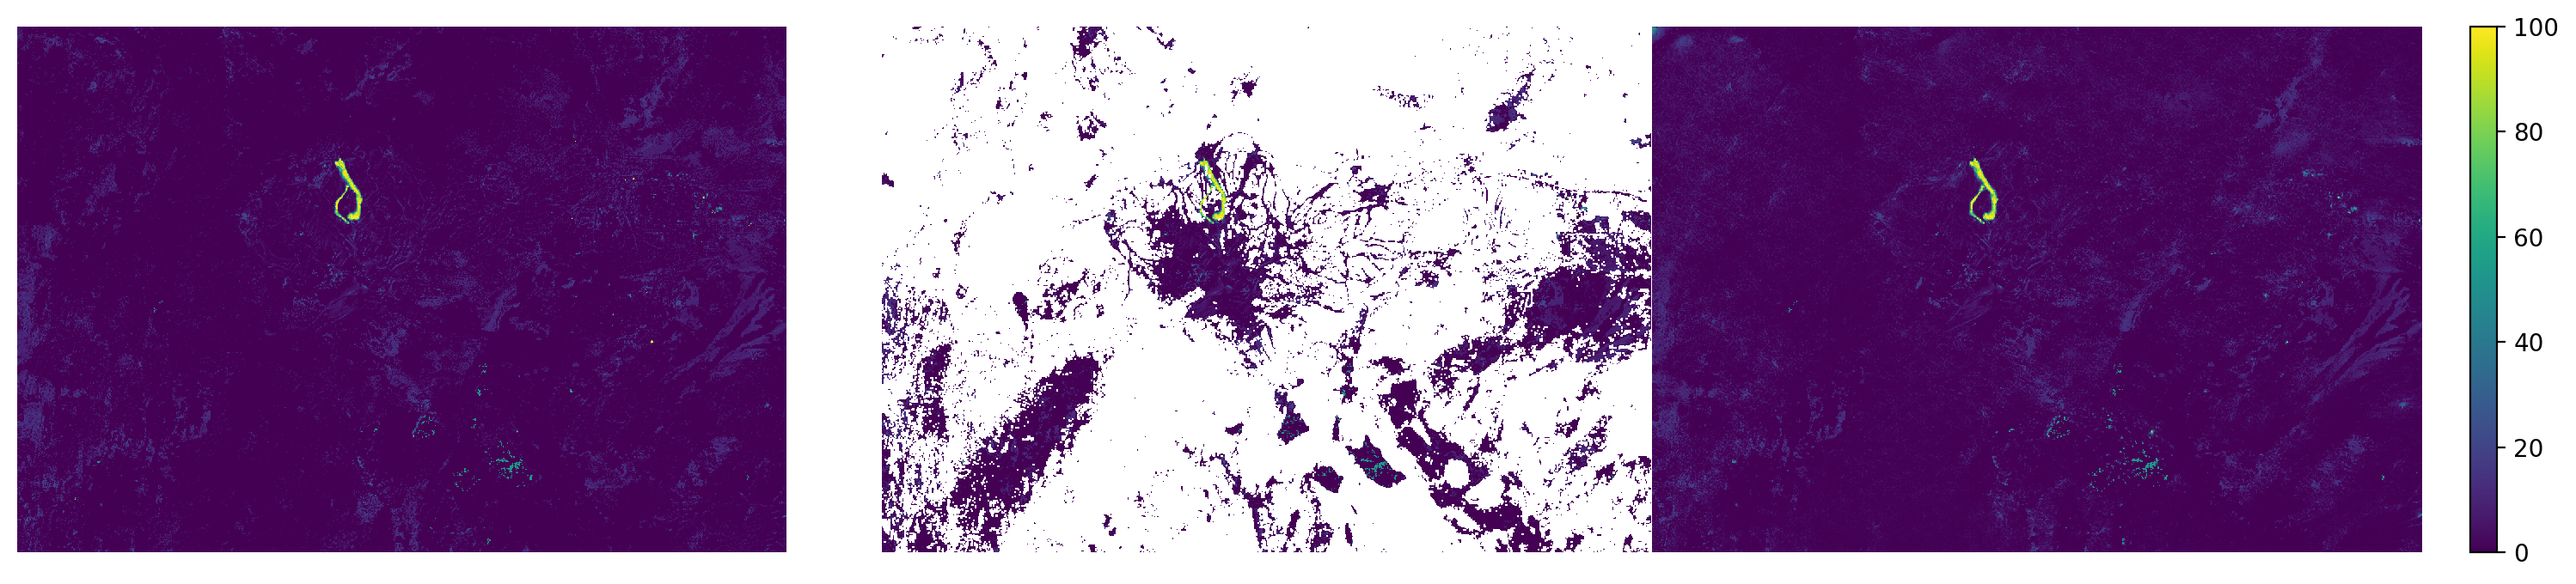

In [138]:
fig

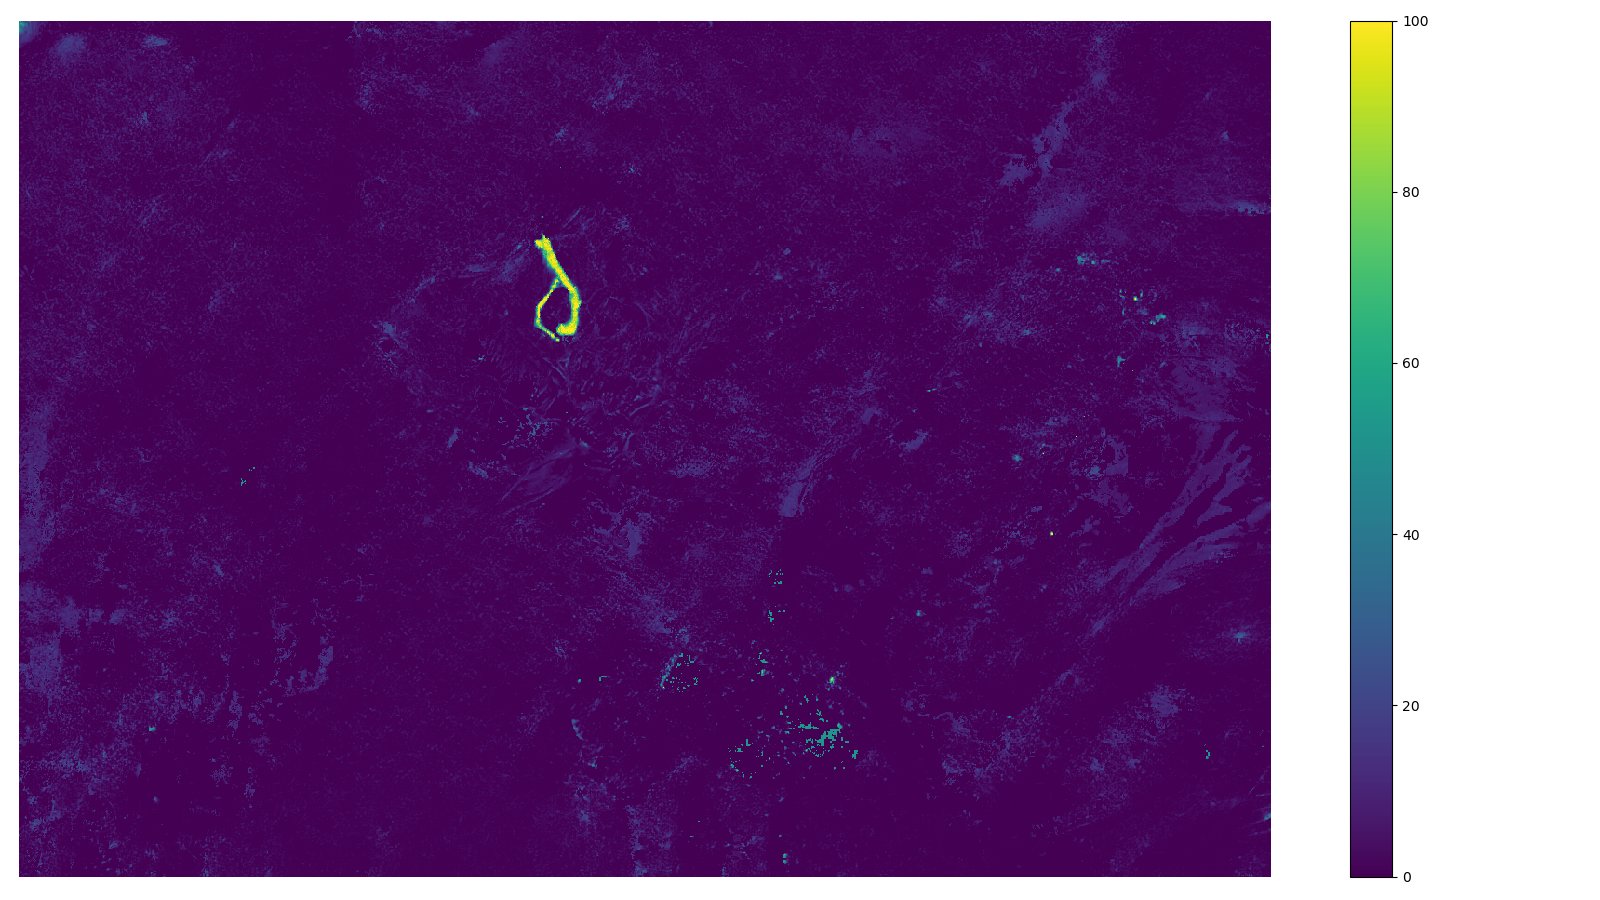

In [139]:
fig, ax = plt.subplots(figsize=(16, 9), dpi=100, nrows=1, ncols=1)

coarse = 1
result_da.coarsen(x=coarse, y=coarse, boundary='trim').mean().plot(ax=ax, add_colorbar=True, alpha=1)

ax.set_aspect('equal')
ax.axis('off')
ax.title.set_visible(False)
fig.tight_layout()

In [74]:
fig.savefig('tree.png')

# Apply for whole cube
- [ ] chunk `result`?
  

In [ ]:
results = []

for time in tqdm(fsca_da['time']):
    fsca_ts = fsca_da.sel(time=time)    
    result = process_in_patches(fsca_ts, mask_da, patch_size_y=patch_size_y, patch_size_x=patch_size_x, overlap=overlap)
    results.append(result)

In [ ]:
%%time
out = xarray.concat(results, dim='time')

In [ ]:
%%time
out = out.chunk({'x': ds.chunks['x'], 'y': ds.chunks['y'], 'time': 1})

In [ ]:
%%time
out = out.assign_coords({'time': fsca_da['time']})

In [ ]:
%%time
fill_value = -1

out = out / 255 * 100
out = xarray.where(np.isnan(out), fill_value, out).astype(np.int8)
out.attrs["_FillValue"] = fill_value

In [ ]:
out = out.to_dataset(name='fsca_treefilled')

# Watermask
https://zenodo.org/records/14899246

In [ ]:
out = out.rio.write_crs(ds['spatial_ref'].attrs['crs_wkt'])
#out = out.rio.write_crs(32610)

In [ ]:
bounds = out.rio.transform_bounds(4326)

In [ ]:
watermask = rioxarray.open_rasterio('/data/watermask/landWater2020_-120_030.tif', chunks='auto').squeeze()
watermask = watermask.drop_vars('band')
watermask = watermask
    
watermask = watermask.rio.reproject_match(out)

In [ ]:
%%time
out = xarray.where(watermask==1, out, np.nan)
out = out.transpose('time', 'y', 'x')

In [ ]:
from dask.distributed import LocalCluster
import dask.distributed
import logging

dask.config.set({'temporary-directory': '/data/dask'})
dask.config.set({'distributed.comm.timeouts.tcp': '1200s'})
dask.config.set({'distributed.comm.timeouts.connect': '1200s'})
dask.config.get('distributed.comm.timeouts')

cluster = dask.distributed.LocalCluster(n_workers=32, 
                                        threads_per_worker=4, # Good question ... 
                                        memory_limit='64GB', 
                                        processes=True,  # Probably a good idea here
                                        dashboard_address='localhost:8787',
                                        silence_logs=logging.ERROR)

client = dask.distributed.Client(cluster) 

In [ ]:
%%time
timestep = 2

fig, ax = plt.subplots(figsize=(16, 9), dpi=250, nrows=1)
ts = out.isel(time=timestep)

ts['fsca_treefilled'].plot(ax=ax)

ax.set_aspect('equal')
ax.axis('off')
ax.title.set_visible(False)
fig.tight_layout()

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

date = ds['time'].isel(time=timestep).dt.strftime('%Y-%m-%d').values
print(date)

In [ ]:
2

In [ ]:
out

In [ ]:
%%time
out.to_zarr(f'/data/sentinel2/zarrs_v3/{region}_postprocessed.zarr/', mode='a')

In [ ]:
client.close()
cluster.close()

In [ ]:
1

In [ ]:
5